<a href="https://colab.research.google.com/github/PavicicJadranko/COVID-19-Analysis/blob/main/COVID_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Data Analysis Project (SQLite + Python)
A full workflow from data collection to visualization

## 1. Setup & Data Collection

In [3]:
#!pip install pandas python-dotenv

In [4]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

### Load and clean the data

We will import the COVID data and prepare it for analysing

In [5]:
# Load the COVID data
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

covid_df = pd.read_csv(url)

covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [6]:
# Cleaning the data
cols =["date", "location", "total_cases", "total_deaths", "population"]
covid_df = covid_df[cols].dropna(subset="total_cases")


covid_df.head()

,date,location,total_cases,total_deaths,population
0,2020-01-05,Afghanistan,0.0,0.0,41128772
1,2020-01-06,Afghanistan,0.0,0.0,41128772
2,2020-01-07,Afghanistan,0.0,0.0,41128772
3,2020-01-08,Afghanistan,0.0,0.0,41128772
4,2020-01-09,Afghanistan,0.0,0.0,41128772


## 2. Create SQLite Database

We use SQLight for storing the `DataFrame`

In [7]:
engine = create_engine('sqlite:///covid.db')
covid_df.to_sql('covid_data', engine, if_exists='replace', index=False)

411804

## 3. Analyze Data

Using SQL querys

In [8]:
# Define query function
def run_query(query):
    return pd.read_sql_query(query, engine)



In [9]:
# Query 1: Top 10 countries by total cases
top_countries = run_query("""
    SELECT location, MAX(total_cases) AS total_cases
    FROM covid_data
    GROUP BY location
    ORDER BY total_cases DESC
    LIMIT 10
""")

print(top_countries)

                        location  total_cases
0                          World  775866783.0
1          High-income countries  429044049.0
2                           Asia  301499099.0
3                         Europe  252916868.0
4  Upper-middle-income countries  251753518.0
5            European Union (27)  185822587.0
6                  North America  124492666.0
7                  United States  103436829.0
8                          China   99373219.0
9  Lower-middle-income countries   91954400.0


In [10]:
# Query 2: Death rate analysis
death_rate = run_query("""
    SELECT
        location,
        MAX(total_deaths) AS deaths,
        Max(total_cases) AS cases,
        ROUND(MAX(total_deaths)*100.0 / MAX(total_cases), 2) AS death_rate
    FROM covid_data
    WHERE total_cases > 10000
    GROUP BY location
    HAVING death_rate > 0
    ORDER BY death_rate DESC
    LIMIT 10
""")

print(death_rate)


                 location    deaths      cases  death_rate
0                   Yemen    2159.0    11945.0       18.07
1                   Sudan    5046.0    63993.0        7.89
2                   Syria    3163.0    57423.0        5.51
3                 Somalia    1361.0    27334.0        4.98
4                    Peru  220975.0  4526977.0        4.88
5                   Egypt   24830.0   516023.0        4.81
6                  Mexico  334551.0  7619458.0        4.39
7  Bosnia and Herzegovina   16392.0   403666.0        4.06
8             Afghanistan    7998.0   235214.0        3.40
9                 Ecuador   36050.0  1077445.0        3.35


# 4. Visualize Results

Text(0.5, 1.0, 'Top 10 Countries by Total Cases')

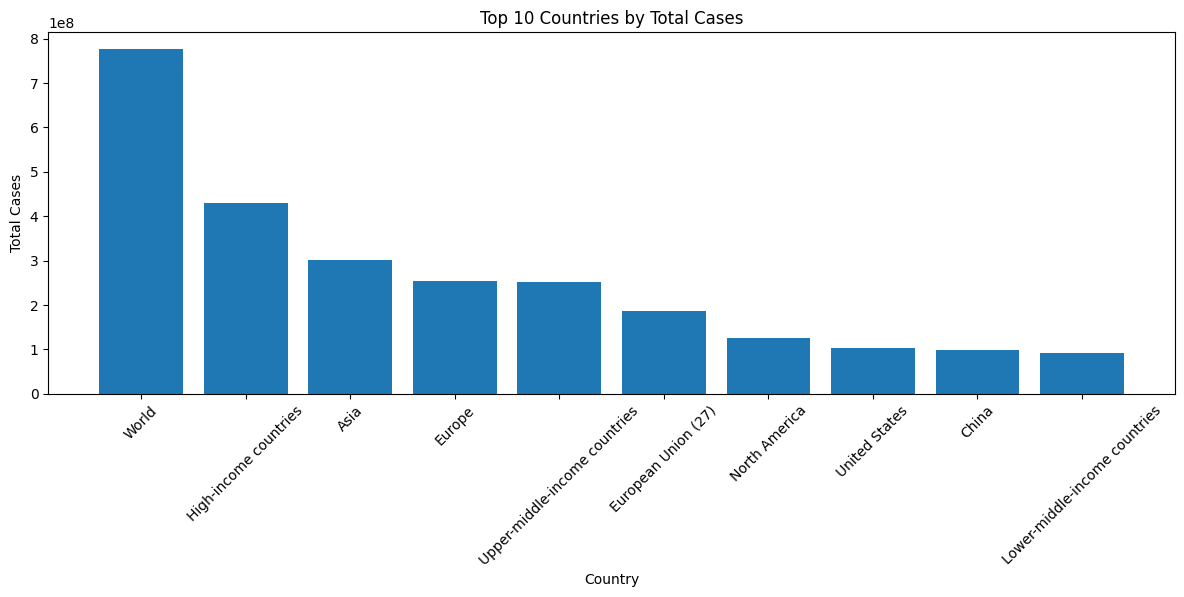

In [14]:
# Plot top countries
plt.figure(figsize=(12, 6))
plt.bar(top_countries['location'], top_countries['total_cases'])
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Total Cases')
plt.tight_layout()
plt.title('Top 10 Countries by Total Cases')

Text(0.5, 1.0, 'Death Rate Analysis')

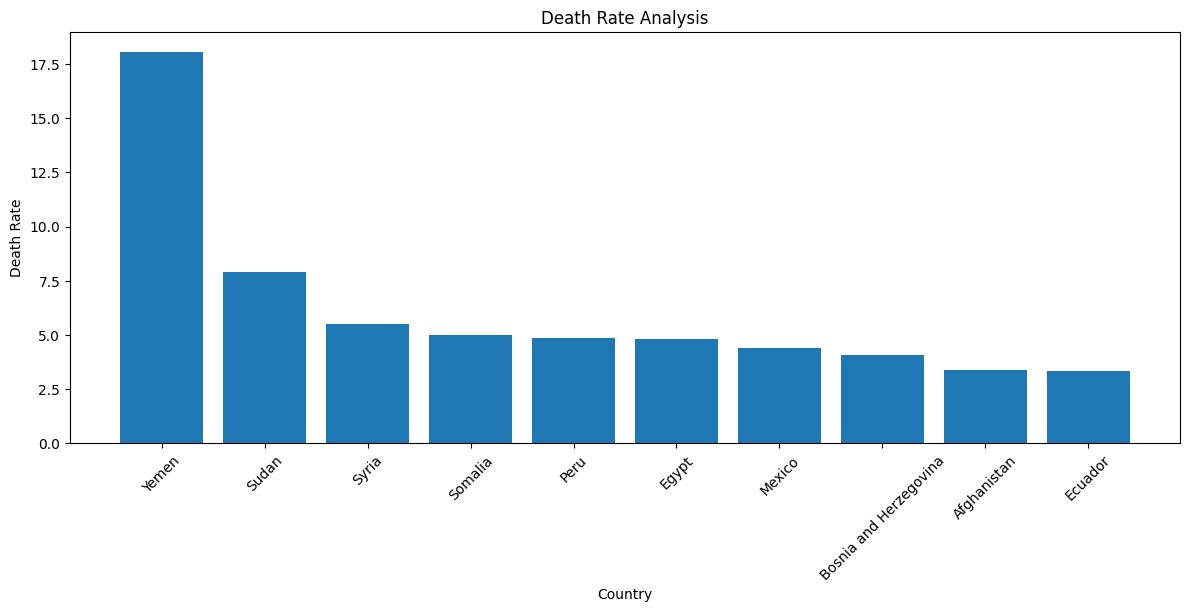

In [16]:
# Plot deth rates
plt.figure(figsize=(12, 6))
plt.bar(death_rate['location'], death_rate['death_rate'])
plt.xlabel('Country')
plt.ylabel('Death Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Death Rate Analysis')
